# Example: Data-Driven Minimum-Variance Portfolio Allocation for Risky Assets
In this example, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. 

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> 
> * **Compute empirical portfolio statistics from historical data.** Calculate expected returns and covariance matrices from market data for selected assets, providing the foundation for quantitative portfolio analysis using observed relationships between securities.
> * **Formulate and solve Markowitz minimum-variance optimization problems.** Set up constrained quadratic optimization problems that minimize portfolio risk for given return targets, using the classical mean-variance framework to find optimal asset allocations.
> * **Generate and analyze efficient frontier curves for risky asset portfolios.** Systematically compute optimal portfolios across different risk-return combinations and visualize the resulting efficient frontier to understand the trade-offs between expected return and portfolio volatility.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [6]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "INFO" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days to ensure we have consistent, complete time series for reliable analysis.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

Now, let's load the GBM parameters that we computed in the previous example:

In [14]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

Next, let's load the covariance matrix that we computed in the previous example:

In [16]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

### Constants and Parameters
Let's define some constants and parameters that we will use in our simulations. See the comments next to each constant for additional information, including values, units, etc.

In [18]:
Δt = (1.0/252.0); # time step (1 trading day, in years)
TSIM = 182; # number of trading days to simulate (1 quarter, in trading days)
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
startdate = Date(2025,1,1); # start date of simulation
risk_free_rate = 0.03815; # benchmark: 10-year T-note 10/03/24

## Task 1: Build the log return array and covariance matrix for a sample portfolio
Modern portfolio theory requires two key inputs: expected returns and the covariance structure between assets. In this task, we will extract these statistics from our historical dataset to prepare for optimization.

We will compute the expected growth (return) vector (we'll approximate this using the drift vector) and the covariance matrix for the assets in a portfolio composed of $M$ risky assets that we choose. Thus, before we compute the efficient frontier, we must decide which tickers to include in the risky portfolio. 

> __Ticker picker question:__ Which assets to include in your portfolio may seem like a simple question, but it turns out to be a hard question to answer, and it can have a __significant impact__ on the performance of your portfolio. There are so many interesting threads that we could pull here. But for now, just pick something. 

Specify a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array. 

In [20]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "NVDA", "GS", "BAC", "WFC", "C", "F", "GM", "JNJ"]; # random tickers that I selected.

Now that we have selected the firms in our risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. 

In [22]:
μ̂, Σ̂ᵣ = let

    # initialize -
    M = length(my_list_of_tickers); # number of assets in portfolio
    μ = Array{Float64,1}(); # drift vector
    Σᵣ = Array{Float64,2}(undef, M, M); # covariance matrix for *our* portfolio
    tickers_in_parameters = parameters_df[:, :ticker] |> collect; # list of tickers in parameters_df
    covariance_ticker_list = covariance_dictionary["list_of_tickers"] |> collect; # list of tickers in covariance dictionary
    Σ = covariance_dictionary["covariance_matrix"]; # full covariance matrix

    # compute drift vector -
    for ticker ∈ my_list_of_tickers
        i = findfirst(x-> x == ticker, tickers_in_parameters); # find index of ticker in the parameters_df
        push!(μ, parameters_df[i, :drift]); # append drift value to μ
    end

    # compute covariance matrix -
    for i ∈ 1:M
        for j ∈ 1:M
            row_index = findfirst(x-> x == my_list_of_tickers[i], covariance_ticker_list); # find row index in full covariance matrix
            col_index = findfirst(x-> x == my_list_of_tickers[j], covariance_ticker_list); # find column index in full covariance matrix
            Σᵣ[i,j] = Σ[row_index, col_index]; # assign value to Σᵣ
        end
    end

    (μ, Σᵣ); # return
end;

In [23]:
μ̂

13-element Vector{Float64}:
  0.24270982336153857
  0.2471358046522564
  0.011808131500890391
  0.15913226678755288
  0.43965769203026206
  0.5032547203526204
  0.09105696245327896
  0.09307620823376395
 -0.013890779060143235
  0.0054446227211617385
 -0.01843599791478546
  0.024455836689585175
  0.05375615545070021

## Task 2: Compute the efficient frontier for your collection of stocks
With our expected returns and covariance matrix in hand, we can now solve the classic Markowitz optimization problem. This will give us the set of portfolios that offer the highest expected return for each level of risk.

In this task, we'll compute the optimal allocation in the minimum variance sense using the tickers in the `my_list_of_tickers::Array{String,1}` vector.

> __What are we going to do?__ Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem), and store this in the `problem_risk` variable using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}_{r}$, the expected return array $\hat{\mu}_{r}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}). Then, we can use the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) for different values of the minimum desired return to compute the efficient frontier.

First, let's set up the bounds and other parameters required for the computation of the portfolio weights along the efficient frontier:

In [25]:
number_of_firms = length(my_list_of_tickers); # how many firms do we have
wₒ = zeros(number_of_firms) # initial allocation (zeros)
wₒ[1] = 1.0; # all money in firm 1
bounds = zeros(number_of_firms,2); 
bounds[:,2] .= 1.0;
number_of_points = 201;

Next, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}), passing in the data for the required fields:

In [27]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂ᵣ, # covariance = risk
    μ = μ̂, # drift = return
    bounds = bounds, # [0,1]
    initial = wₒ, # initial allocation
    R = 0.0 # desired return
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. In this example, let's start at `0` and go up to `20`$\times{r_{f}}$ annualized return using `number_of_points`:

In [29]:
minimum_desired_reward_array = range(0.0, stop = 20*risk_free_rate, length = number_of_points) |> collect; # R

What's in the `minimum_desired_reward_array::Array{Float64,1}` array?

In [31]:
minimum_desired_reward_array

201-element Vector{Float64}:
 0.0
 0.0038150000000000007
 0.007630000000000001
 0.011445000000000002
 0.015260000000000003
 0.019075
 0.022890000000000004
 0.026705000000000003
 0.030520000000000005
 0.034335000000000004
 0.03815
 0.04196500000000001
 0.04578000000000001
 ⋮
 0.7210350000000001
 0.7248500000000001
 0.7286650000000001
 0.7324800000000001
 0.7362950000000001
 0.7401100000000002
 0.7439250000000002
 0.7477400000000001
 0.7515550000000001
 0.7553700000000001
 0.7591850000000001
 0.7630000000000001

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for-loop`.

For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [33]:
efficient_frontier = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_risk.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_risk)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk -
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # TODO: need to update this key
                
                
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_risk.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

What's in the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary?

In [73]:
efficient_frontier

Dict{Float64, NamedTuple} with 132 entries:
  0.0187713 => (risk = 0.0187713, reward = 0.0924055, w = [0.0901429, 0.14233, …
  0.0683044 => (risk = 0.0683044, reward = 0.370055, w = [0.180574, 0.319448, 1…
  0.123483  => (risk = 0.123483, reward = 0.469245, w = [0.0137927, 0.0931201, …
  0.0215558 => (risk = 0.0215558, reward = 0.16786, w = [0.139627, 0.225405, 2.…
  0.0187713 => (risk = 0.0187713, reward = 0.0924051, w = [0.0901418, 0.142329,…
  0.0342504 => (risk = 0.0342504, reward = 0.255605, w = [0.178264, 0.296047, 5…
  0.0326941 => (risk = 0.0326941, reward = 0.247975, w = [0.175092, 0.290077, 6…
  0.131707  => (risk = 0.131707, reward = 0.48069, w = [8.31273e-7, 0.0615112, …
  0.0570743 => (risk = 0.0570743, reward = 0.339535, w = [0.213152, 0.361706, 2…
  0.0187713 => (risk = 0.0187713, reward = 0.0924051, w = [0.0901418, 0.142329,…
  0.0187713 => (risk = 0.0187713, reward = 0.0924051, w = [0.0901418, 0.142329,…
  0.0822087 => (risk = 0.0822087, reward = 0.400575, w = [0.12925

In [71]:
efficient_frontier[0.0486777]

LoadError: KeyError: key 0.0486777 not found

### Organize efficient frontier results into a matrix for analysis and visualization
Transform the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary into a matrix format for plotting and analysis.

> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array::Array{Float64,2}` matrix. Sort portfolios by risk level and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Portfolio risk (standard deviation = √variance)  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the `results_array::Array{Float64,2}` from our efficient frontier solutions:

In [37]:
results_array = let

    # initialize -
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

132×15 Matrix{Float64}:
 0.137008  0.0924053  0.0901426   0.14233      …   0.00205028   0.627754
 0.137008  0.0924055  0.0901429   0.14233          0.00205083   0.627754
 0.137008  0.0924052  0.0901423   0.14233          0.00205415   0.627754
 0.137008  0.0924052  0.0901421   0.14233          0.00205635   0.627754
 0.137008  0.0924052  0.090142    0.14233          0.00205724   0.627754
 0.137008  0.0924051  0.090142    0.14233      …   0.00205777   0.627754
 0.137008  0.0924051  0.0901419   0.14233          0.00205811   0.627754
 0.137008  0.0924051  0.0901419   0.142329         0.00205829   0.627755
 0.137008  0.0924051  0.0901419   0.142329         0.00205833   0.627755
 0.137008  0.0924051  0.0901419   0.14233          0.00205835   0.627755
 0.137008  0.0924051  0.0901419   0.142329     …   0.00205841   0.627755
 0.137008  0.0924051  0.0901419   0.142329         0.00205846   0.627755
 0.137008  0.0924051  0.0901419   0.14233          0.0020585    0.627755
 ⋮                         

### Visualize the efficient frontier
Now that we have computed the optimal portfolios, let's visualize the classic risk-return trade-off that Markowitz theory reveals. The efficient frontier shows the boundary of achievable risk-return combinations for our selected assets.

`Unhide` the code block below to see how we plotted the efficient frontier for the collection of equities and ETFs specified in the `my_list_of_tickers::Array{String,1}` array.

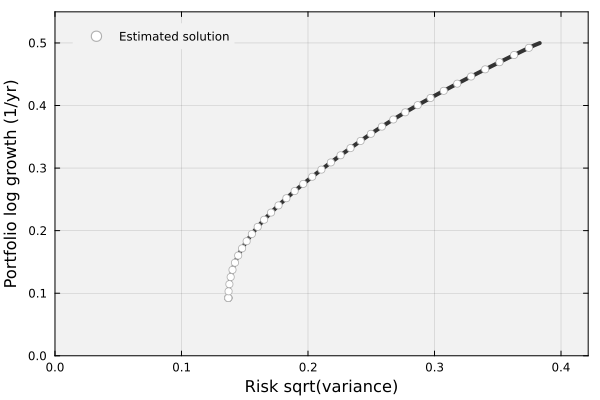

In [39]:
let

    # initialize -
    max_risk_value = results_array[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios = length(efficient_frontier); # how many portfolios did we recover?
    skip = 3;

    plot(results_array[:,1], results_array[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="", c=:gray20, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array[1:skip:number_of_portfolios,1], results_array[1:skip:number_of_portfolios,2], 
        label="Estimated solution", c=:white, ms=4, msc=:gray69)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### What's in the minimum-variance portfolio?
The efficient frontier reveals which combinations of assets provide optimal risk-return trade-offs. Let's examine a specific portfolio from our results to understand how the optimization allocates capital across different assets.

We can extract the allocation values from the results_array to see which assets were selected and in what proportions.

In [81]:
index_to_view = 132; # index = 1 will give the min-var portfolio, index = max gives the high-risk high-reward portfolio

`Unhide` the code block below to see how we build a table holding the portfolio weights for the selected portfolio:

In [83]:
let

    # initialize -
    w = results_array[index_to_view, 3:end]; # 3:end gives the allocations
    df = DataFrame();
    
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        wᵢ = w[i];
        row_data = (
            ticker = ticker,
            w = round(wᵢ, digits=4) |> abs
        );
        push!(df,row_data)
    end
    
    # compute the total -
    total = df[:,:w] |> sum
    last_row = (
        ticker = "total",
        w = total
    )
    push!(df,last_row)
    

     # build a table -
    pretty_table(df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact))
end

 -------- ---------
  ticker         w 
  String   Float64 
 -------- ---------
    AAPL       0.0
    MSFT       0.0
    INTC       0.0
      MU       0.0
     AMD    0.0549
    NVDA    0.9451
      GS       0.0
     BAC       0.0
     WFC       0.0
       C       0.0
       F       0.0
      GM       0.0
     JNJ       0.0
   total       1.0
 -------- ---------


___

## Summary
In this example, we implemented a complete data-driven approach to modern portfolio theory, computing the efficient frontier for a portfolio of risky assets using historical market data.

> __Key Takeaways:__
> * **Historical data provides empirical inputs for portfolio optimization.** By computing sample means and covariance matrices from real price data, we obtain the statistical parameters needed for Markowitz optimization, though these estimates reflect past relationships that may not persist in the future.
>
> * **Markowitz optimization balances expected return against portfolio risk.** The minimum-variance framework systematically estimates optimal asset allocations that minimize portfolio variance for each target return level, providing a mathematical foundation for understanding risk-return trade-offs in portfolio construction.
>
> * **The efficient frontier reveals the limits of diversification benefits.** By plotting optimal portfolios across different return targets, we visualize the boundary of achievable risk-return combinations, showing how diversification can reduce risk without sacrificing expected return up to the frontier's limits.

This framework demonstrates how quantitative methods can guide portfolio construction decisions, though real-world implementation requires careful consideration of parameter estimation uncertainty, changing market conditions, and many other factors. But it is a start!
___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.